## Trying out ideas for a flexible sliding window function

In [1]:
import os
tmp = os.getcwd()
os.chdir(tmp.split("jmspack")[0] + "jmspack")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jmspack.utils import (
                              apply_scaling
                          )

from jmspack.utils import JmsColors

In [3]:
os.chdir(tmp)

In [4]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [5]:
if "jms_style_sheet" in plt.style.available:
    _ = plt.style.use("jms_style_sheet")

In [6]:
def change_profile(x, window_size):
#     window_size = 5
#     x=ts
    window_range = np.arange(0, len(x)-window_size, window_size)

    cp_df = pd.DataFrame()
    for window_begin in window_range:
        window_mean = x.iloc[window_begin: window_begin + window_size].mean()
        window_sum = x.iloc[window_begin: window_begin + window_size].sum()
        
#         current_cp_df = x.iloc[window_begin: window_begin + window_size] - window_mean

        current_cp_df = (x.iloc[window_begin: window_begin + window_size] - window_sum) / window_size
        cp_df = pd.concat([cp_df, current_cp_df])
        
    return cp_df[0]

In [7]:
def win_PCA(x, window_size):
#     window_size = 5
#     x=ts
    window_range = np.arange(0, len(x)-window_size, window_size)

    cp_df = pd.DataFrame()
    for window_begin in window_range:
        current_cp_df = pd.DataFrame(PCA(n_components=None).fit_transform(x.iloc[window_begin: window_begin + window_size])).iloc[:, 0]
        cp_df = pd.concat([cp_df, current_cp_df])
        
    return cp_df[0]

In [8]:
def win_LDA(x, window_size):
#     window_size = 5
#     x=ts
    window_range = np.arange(0, len(x)-window_size, window_size)

    cp_df = pd.DataFrame()
    for window_begin in window_range:
        current_cp_df = pd.DataFrame(LinearDiscriminantAnalysis(n_components=None).fit_transform(X=x.iloc[window_begin: window_begin + window_size],
                                                                                                y=np.repeat(1, repeats=window_size))).iloc[:, 0]
        cp_df = pd.concat([cp_df, current_cp_df])
        
    return cp_df[0]

In [9]:
def change_profile_apply(x):
    window_sum = x.sum()
    window_size = x.shape[0]
    return (x - window_sum) / window_size

In [10]:
def flexy_window(x, window_size, user_func):
    x.rolling
    
    return win_df[0]

In [11]:
def mad(x):
    return np.fabs(x - x.mean()).mean()

In [12]:
ts_name = "lorenz"

In [13]:
df = pd.read_csv("../datasets/time_series_dataset.csv", index_col=0).head(500)

In [14]:
ts_df = pd.read_csv("../datasets/time_series_dataset.csv", index_col=0)[[ts_name]].head(500)

In [15]:
ts_df[ts_name]

0      -0.156058
1      -0.071057
2       0.004560
3       0.072342
4       0.133683
         ...    
495   -13.234793
496   -13.758987
497   -14.212115
498   -14.576715
499   -14.836584
Name: lorenz, Length: 500, dtype: float64

In [16]:
# ts_df[ts_name].rolling(window=3).apply(lambda x: (x - x.sum())/ x.shape[0])
# ts_df[ts_name].rolling(window=3).apply(change_profile_apply)
ts_df[ts_name].rolling(window=3).apply(mad)

0           NaN
1           NaN
2      0.054582
3      0.048670
4      0.043757
         ...   
495    0.401457
496    0.373237
497    0.333670
498    0.282412
499    0.219793
Name: lorenz, Length: 500, dtype: float64

In [17]:
plot_df = (ts_df
 .assign(**{f"{ts_name}_cp": change_profile(x=ts_df[ts_name], window_size=5),
            f"{ts_name}_mad": lambda d: d[ts_name].rolling(window=5).apply(mad),
            f"{ts_name}_mean": lambda d: d[ts_name].rolling(window=25).mean(),
            f"{ts_name}_scaled_sum": lambda d: d.pipe(apply_scaling)[ts_name].rolling(window=25).sum(),
#             f"all_df_PCA": win_PCA(df, window_size=5).append(pd.Series(np.repeat(np.nan, 5))).reset_index(drop=True)
           })
           .reset_index()
 .melt(id_vars="index")
           
)

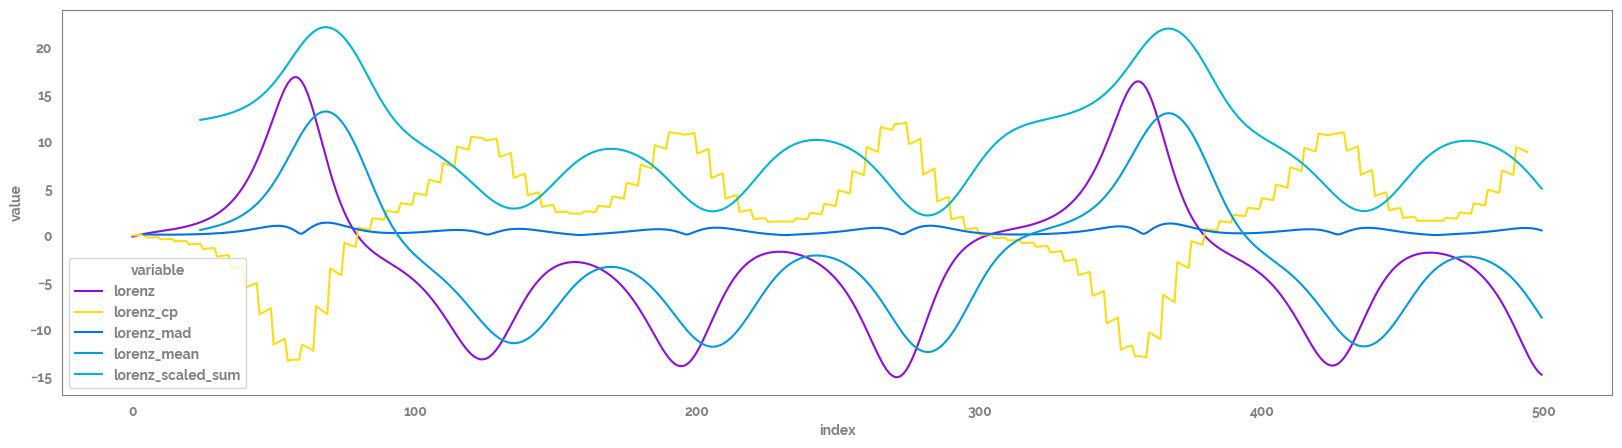

In [18]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=plot_df,
                x="index",
                y="value",
                hue="variable")

In [19]:
# win_LDA(df, window_size=5)

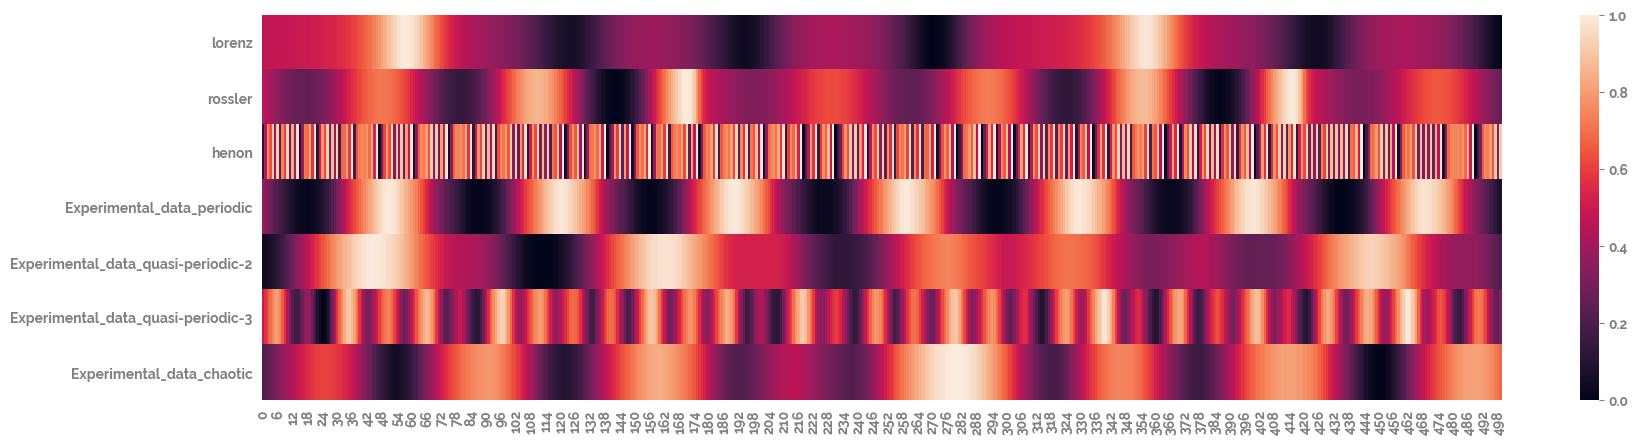

In [20]:
_ = plt.figure(figsize=(20, 5))
_ = sns.heatmap(df.pipe(apply_scaling).T)

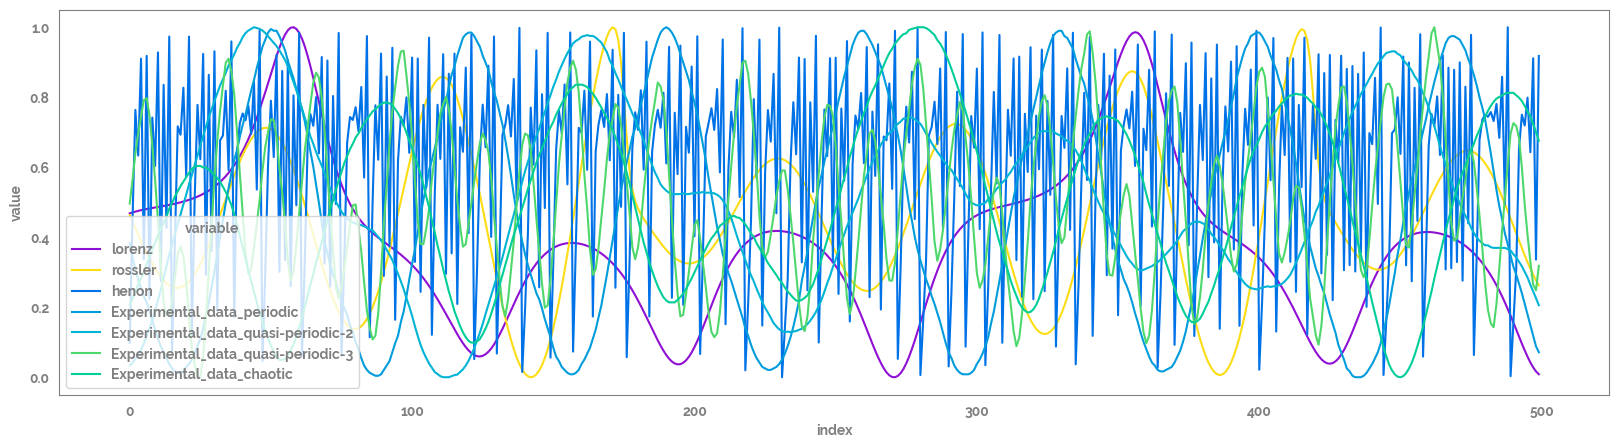

In [21]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=df.pipe(apply_scaling)
                 .reset_index()
                 .melt(id_vars="index"),
                x="index",
                y="value",
                hue="variable")

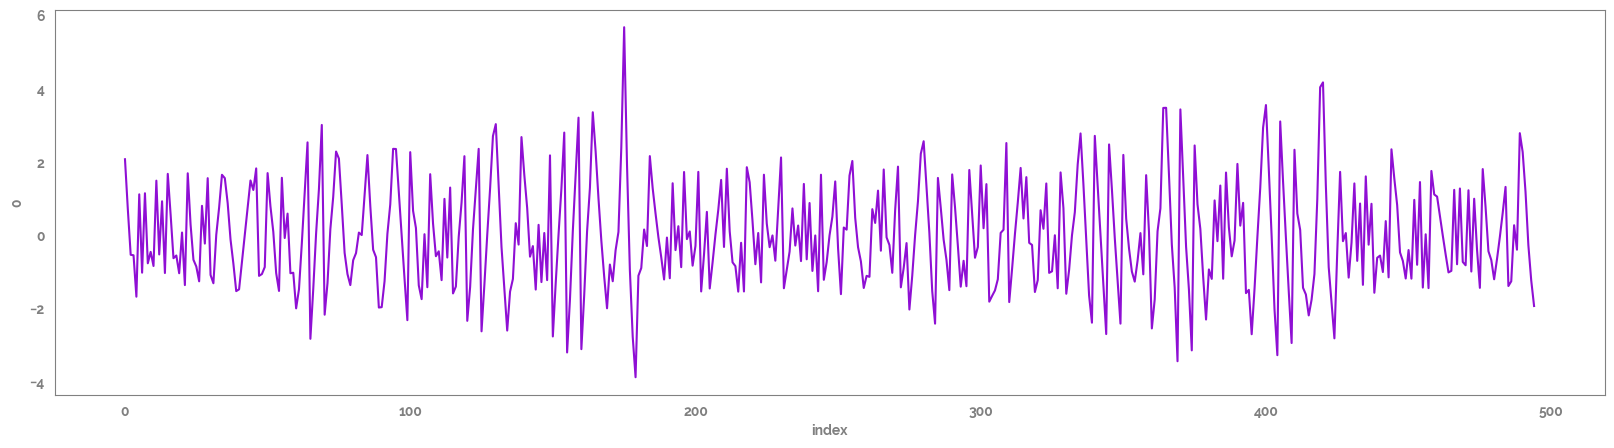

In [22]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=win_PCA(df, window_size=5).reset_index(drop=True).reset_index(),
                x="index",
                y=0)

In [23]:
# _ = plt.figure(figsize=(20, 5))
# _ = sns.lineplot(data=win_LDA(df, window_size=5).reset_index(drop=True).reset_index(),
#                 x="index",
#                 y=0)